# DP-CGAN: Differentially Private Conditional GAN - TensorFlow 2

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ricardocarvalhods/dpcgan/blob/master/DP_CGAN_MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/ricardocarvalhods/dpcgan/blob/master/DP_CGAN_MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>
<br/><br/><br/>

**Author**: 
- Ricardo S. Carvalho
    - PhD Student at Simon Fraser University
    - Please feel free to get in touch via (rsilvaca [at] sfu [dot] ca)
    - Personal website: [ricardocarvalho.ca](http://ricardocarvalho.ca/)

**Content**:
- This notebook contains the implementation of a Differentially Private Conditional GAN, originally described on [Torkzadehmahani et al. 2019](http://openaccess.thecvf.com/content_CVPRW_2019/papers/CV-COPS/Torkzadehmahani_DP-CGAN_Differentially_Private_Synthetic_Data_and_Label_Generation_CVPRW_2019_paper.pdf).
- We include a TF 2 version implemented from scratch, using the Keras API and a `tf.GradientTape` training loop.
- To successfully use DP on a Conditional GAN, we design a **custom optimizer**.
- We include results on the MNIST dataset.

**References**:
- The GAN implementation was inspired by TensorFlow's tutorial on Convolutional GANs, which can be found [here](https://www.tensorflow.org/tutorials/generative/dcgan).
- The DP integration was inspired by TF Privacy's tutorial on DPSGD on eager Keras, available [on this link](https://github.com/tensorflow/privacy/blob/master/tutorials/mnist_dpsgd_tutorial_eager.py).
- The DP conditional application follows ideas from the original TF 1.15 code on [this github repository](https://github.com/reihaneh-torkzadehmahani/DP-CGAN), with some modifications to clear inconsistencies in the code. We further discussed the differences in a [report](https://github.com/ricardocarvalhods/dpcgan/blob/master/report.pdf).

**Acknowledgments**:
- We thank the **first author of the DP-CGAN**, Reihaneh Torkzadehmahani, for clarifying the settings used in their work and for fruitful discussions about the framework. 
- Additionally, we thank **Google privacy engineers** Galen Andrew, Steve Chien and Brendan McMahan for helping with important questions about TF privacy.

**Pre-requisites**:
- We consider the following are known to anyone using this notebook:
    - Generative Adversarial Networks (GANs): Knowledge of how they work, especially loss functions.
        - Suggestion of reference: [Udacity videos from Goodfellow on GANs](https://mc.ai/generative-adversarial-networks-gans-by-udacity-the-complete-youtube-playlist/).
    - Differential Privacy (DP): Basic knowledge to know what the privacy parameters mean when stating a mechanism is (epsilon, delta)-differentially private.
        - DP-SGD: Understanding main modifications needed to SGD to make it differentially private.
        - Suggestion of reference: [blog post of DP-SGD on TF](http://www.cleverhans.io/privacy/2019/03/26/machine-learning-with-differential-privacy-in-tensorflow.html) and [tutorials on TF Privacy](https://github.com/tensorflow/privacy/tree/master/tutorials).

---

## Introduction

We implement a conditional GAN ([Mirza and Osindero, 2014](https://arxiv.org/abs/1411.1784)), which is a GAN where both Discriminator and Generator are conditioned on some information, such as labels. Additionally, we want to protect the privacy of the training data, as we know ([Hayes et. al, 2017](https://arxiv.org/abs/1705.07663)) it is possible to perform membership inference on it. So to address this problem, we use differential privacy on the GAN training by applying DP-SGD from [Abadi et. al, 2016](https://arxiv.org/abs/1607.00133).

Generally, DP-SGD enforces privacy by clipping gradients individually and adding Gaussian noise -- to learn more about DP-SGD and its use with TF, I recommend [this excellent post](http://www.cleverhans.io/privacy/2019/03/26/machine-learning-with-differential-privacy-in-tensorflow.html). Since only the Discriminator has access to the private data, we have to use DP-SGD only during the Discriminator training. 

However, Discriminator learns via both private data and the generated data (output of Generator). Since the generated data is not sensitive, as it is created from noise, we do not need to apply DP-SGD and modify the gradients for the discriminator when learning from the generated data. For this reason we modify the discriminator's optimizer to only add noise to the gradients when learning from the real data, and not add noise when learning from the generated data. Moreover, we combine gradients from both real and generated on a single update step, following the approach from [Torkzadehmahani et al. 2019](http://openaccess.thecvf.com/content_CVPRW_2019/papers/CV-COPS/Torkzadehmahani_DP-CGAN_Differentially_Private_Synthetic_Data_and_Label_Generation_CVPRW_2019_paper.pdf).

---

## Imports

### Connect to Drive

In [0]:
ROOT = '/content/gdrive'

In [0]:
# Connect to Google Drive
# Only run this cell if on Google Colab
from google.colab import drive
drive.mount(ROOT, force_remount=True)

### General imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'2.1.0-rc1'

In [0]:
# To use Differential Privacy
!pip install tensorflow_privacy

In [0]:
# To create models for validation and testing
!pip install sklearn

In [0]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
import time

from IPython import display

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

In [0]:
# Method obtained from https://stackoverflow.com/questions/41123879/numpy-random-choice-in-tensorflow
def _random_choice(inputs, n_samples):
    """
    With replacement.
    Params:
      inputs (Tensor): Shape [n_states, n_features]
      n_samples (int): The number of random samples to take.
    Returns:
      sampled_inputs (Tensor): Shape [n_samples, n_features]
    """
    # (1, n_states) since multinomial requires 2D logits.
    uniform_log_prob = tf.expand_dims(tf.zeros(tf.shape(inputs)[0]), 0)

    ind = tf.compat.v1.multinomial(uniform_log_prob, n_samples)
    ind = tf.squeeze(ind, 0, name="random_choice_ind")  # (n_samples,)

    return tf.gather(inputs, ind, name="random_choice")

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_curve, auc
ConvergenceWarning('ignore')

sklearn.exceptions.ConvergenceWarning('ignore')

In [0]:
# Method obtained from https://github.com/reihaneh-torkzadehmahani/DP-CGAN
def compute_fpr_tpr_roc(Y_test, Y_score):
    n_classes = Y_score.shape[1]
    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()
    for class_cntr in range(n_classes):
        false_positive_rate[class_cntr], true_positive_rate[class_cntr], _ = roc_curve(Y_test[:, class_cntr],
                                                                                       Y_score[:, class_cntr])
        roc_auc[class_cntr] = auc(false_positive_rate[class_cntr], true_positive_rate[class_cntr])

    # Compute micro-average ROC curve and ROC area
    false_positive_rate["micro"], true_positive_rate["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(false_positive_rate["micro"], true_positive_rate["micro"])

    return false_positive_rate, true_positive_rate, roc_auc

## Modified Optimizer for DP

The optimizer below is a modification of the original from TF Privacy, [available here](https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/optimizers/dp_optimizer.py) to allow setting different values of noise multipliers and clipping factor on different steps of the optimization.

The main modification lies on the `compute_gradients` method, which now includes:
- *curr_noise_mult*: Current noise_multiplier
- *curr_norm_clip*: Current L2 norm clipping factor

On every step of the optimization we now additionally pass these parameters to control the privacy effects.

In [0]:
from absl import logging
import collections

from tensorflow_privacy.privacy.analysis import privacy_ledger
from tensorflow_privacy.privacy.dp_query import gaussian_query

def make_optimizer_class(cls):
  """Constructs a DP optimizer class from an existing one."""
  parent_code = tf.compat.v1.train.Optimizer.compute_gradients.__code__
  child_code = cls.compute_gradients.__code__
  GATE_OP = tf.compat.v1.train.Optimizer.GATE_OP  # pylint: disable=invalid-name
  if child_code is not parent_code:
    logging.warning(
        'WARNING: Calling make_optimizer_class() on class %s that overrides '
        'method compute_gradients(). Check to ensure that '
        'make_optimizer_class() does not interfere with overridden version.',
        cls.__name__)

  class DPOptimizerClass(cls):
    """Differentially private subclass of given class cls."""

    _GlobalState = collections.namedtuple(
      '_GlobalState', ['l2_norm_clip', 'stddev'])
    
    def __init__(
        self,
        dp_sum_query,
        num_microbatches=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg, g-doc-args
        **kwargs):
      """Initialize the DPOptimizerClass.

      Args:
        dp_sum_query: DPQuery object, specifying differential privacy
          mechanism to use.
        num_microbatches: How many microbatches into which the minibatch is
          split. If None, will default to the size of the minibatch, and
          per-example gradients will be computed.
        unroll_microbatches: If true, processes microbatches within a Python
          loop instead of a tf.while_loop. Can be used if using a tf.while_loop
          raises an exception.
      """
      super(DPOptimizerClass, self).__init__(*args, **kwargs)
      self._dp_sum_query = dp_sum_query
      self._num_microbatches = num_microbatches
      self._global_state = self._dp_sum_query.initial_global_state()
      # TODO(b/122613513): Set unroll_microbatches=True to avoid this bug.
      # Beware: When num_microbatches is large (>100), enabling this parameter
      # may cause an OOM error.
      self._unroll_microbatches = unroll_microbatches

    def compute_gradients(self,
                          loss,
                          var_list,
                          gate_gradients=GATE_OP,
                          aggregation_method=None,
                          colocate_gradients_with_ops=False,
                          grad_loss=None,
                          gradient_tape=None,
                          curr_noise_mult=0,
                          curr_norm_clip=1):

      self._dp_sum_query = gaussian_query.GaussianSumQuery(curr_norm_clip, 
                                                           curr_norm_clip*curr_noise_mult)
      self._global_state = self._dp_sum_query.make_global_state(curr_norm_clip, 
                                                                curr_norm_clip*curr_noise_mult)
      

      # TF is running in Eager mode, check we received a vanilla tape.
      if not gradient_tape:
        raise ValueError('When in Eager mode, a tape needs to be passed.')

      vector_loss = loss()
      if self._num_microbatches is None:
        self._num_microbatches = tf.shape(input=vector_loss)[0]
      sample_state = self._dp_sum_query.initial_sample_state(var_list)
      microbatches_losses = tf.reshape(vector_loss, [self._num_microbatches, -1])
      sample_params = (self._dp_sum_query.derive_sample_params(self._global_state))

      def process_microbatch(i, sample_state):
        """Process one microbatch (record) with privacy helper."""
        microbatch_loss = tf.reduce_mean(input_tensor=tf.gather(microbatches_losses, [i]))
        grads = gradient_tape.gradient(microbatch_loss, var_list)
        sample_state = self._dp_sum_query.accumulate_record(sample_params, sample_state, grads)
        return sample_state
    
      for idx in range(self._num_microbatches):
        sample_state = process_microbatch(idx, sample_state)

      if curr_noise_mult > 0:
        grad_sums, self._global_state = (self._dp_sum_query.get_noised_result(sample_state, self._global_state))
      else:
        grad_sums = sample_state

      def normalize(v):
        return v / tf.cast(self._num_microbatches, tf.float32)

      final_grads = tf.nest.map_structure(normalize, grad_sums)
      grads_and_vars = final_grads#list(zip(final_grads, var_list))
    
      return grads_and_vars

  return DPOptimizerClass


def make_gaussian_optimizer_class(cls):
  """Constructs a DP optimizer with Gaussian averaging of updates."""

  class DPGaussianOptimizerClass(make_optimizer_class(cls)):
    """DP subclass of given class cls using Gaussian averaging."""

    def __init__(
        self,
        l2_norm_clip,
        noise_multiplier,
        num_microbatches=None,
        ledger=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg
        **kwargs):
      dp_sum_query = gaussian_query.GaussianSumQuery(
          l2_norm_clip, l2_norm_clip * noise_multiplier)

      if ledger:
        dp_sum_query = privacy_ledger.QueryWithLedger(dp_sum_query,
                                                      ledger=ledger)

      super(DPGaussianOptimizerClass, self).__init__(
          dp_sum_query,
          num_microbatches,
          unroll_microbatches,
          *args,
          **kwargs)

    @property
    def ledger(self):
      return self._dp_sum_query.ledger

  return DPGaussianOptimizerClass

In [0]:
GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
DPGradientDescentGaussianOptimizer_NEW = make_gaussian_optimizer_class(GradientDescentOptimizer)

## Output setup

Folder definitions for storing saved models and plots of generated images throughout training.

In [0]:
# Edit to define folder
result_dir = ROOT + '/My Drive/GAN/DPCGAN'

In [0]:
# DO NOT EDIT THIS CELL

# Define checkpoint dir and prefix
checkpoint_dir = result_dir + '/training_checkpoints'

def checkpoint_name(title):  
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt__" + str(title))
  return(checkpoint_prefix)

In [0]:
# DO NOT EDIT THIS CELL

images_dir = result_dir + '/images'

def generate_and_save_images(title, model, epoch, test_input, test_label):
  # Notice `training` is set to False: This is so all layers run in inference mode (batchnorm).
  predictions = model([test_input, test_label], training=False)

  fig = plt.figure(figsize=(2,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 1, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(images_dir + '/' + title + '___image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
if not os.path.exists(result_dir):
  os.makedirs(result_dir)

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

if not os.path.exists(images_dir):
  os.makedirs(images_dir)

## Dataset

Loading **MNIST** and creating hot encoding for labels.

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_labels = train_labels.reshape((60000, 1))
COND_num_classes = 10 # Number of classes, set to 10 for MNIST dataset
train_labels_vec = np.zeros((len(train_labels), COND_num_classes), dtype='float32')
for i, label in enumerate(train_labels):
    train_labels_vec[i, int(train_labels[i])] = 1.0

11493376/11490434 [==============================] - 0s 0us/step


## C-GAN Models

Both Generator and Discriminator follow simple architectures, with fully connected neural networks.

We emphasize the use of C-GAN, therefore conditioning the models to the label information - notice the additional input on both networks below for labels.

In [0]:
# Dimension of Latent Space - Does NOT affect DP-EPSILON
Z_DIM = 100

In [0]:
def make_generator_model_FCC():
    # INPUT: label input
    in_label = layers.Input(shape=(COND_num_classes,))

    # INPUT: image generator input
    in_lat = layers.Input(shape=(Z_DIM,))

    # MERGE
    merge = layers.concatenate([in_lat, in_label], axis=1)

    ge1 = layers.Dense(128, use_bias=True)(merge)
    ge1 = layers.ReLU()(ge1)

    ge2 = layers.Dense(784, use_bias=True, activation="tanh")(ge1)
    out_layer = layers.Reshape((28, 28, 1))(ge2)

    model = models.Model([in_lat, in_label], out_layer)

    return model

def make_discriminator_model_FCC():
    # INPUT: Label
    in_label = layers.Input(shape=(COND_num_classes,))

    # INPUT: Image
    in_image = layers.Input(shape=(28, 28, 1))
    in_image_b = layers.Flatten()(in_image)

    # MERGE
    merge = layers.concatenate([in_image_b, in_label], axis=1)

    ge1 = layers.Dense(128, use_bias=True)(merge)
    ge1 = layers.ReLU()(ge1)

    out_layer = layers.Dense(1, use_bias=True)(ge1)

    model = models.Model([in_image, in_label], out_layer)

    return model

### Initiate and test models

In [0]:
generator = make_generator_model_FCC()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          14208       concatenate[0][0]            

In [0]:
discriminator = make_discriminator_model_FCC()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           flatten[0][0]                    
                                                                 input_3[0][0]              

(1, 100)
(1, 10)
tf.Tensor([[-0.10687535]], shape=(1, 1), dtype=float32)


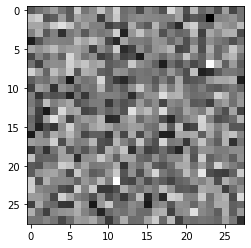

In [0]:
# Test GEN created
noise = tf.Variable(tf.random.normal([1, Z_DIM]))
noise_label = tf.Variable(np.array([0,0,1,0,0,0,0,0,0,0], dtype='float32').reshape((1,10)))
print(noise.shape)
print(noise_label.shape)
generated_image = generator([noise, noise_label], training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Test DISC created
decision = discriminator([generated_image, noise_label])
print(decision)

### Loss and Updates

- Please note that, during the training step of the Discriminator `train_step_DISC`, we **combine gradients** from both real and generated on a single update step into `sanitized_grads_and_vars`, following the approach from [Torkzadehmahani et al. 2019](http://openaccess.thecvf.com/content_CVPRW_2019/papers/CV-COPS/Torkzadehmahani_DP-CGAN_Differentially_Private_Synthetic_Data_and_Label_Generation_CVPRW_2019_paper.pdf).
- When learning from the **real/training dataset** we <u>clip and add noise</u> to the gradients of the Discriminator.
- When learning from the **generated data** we <u>only clip</u> the gradients of the Discriminator.

In [0]:
cross_entropy_DISC = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
cross_entropy_GEN = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Notice the use of `tf.function`: This annotation causes the function to be "compiled".
@tf.function
def train_step_DISC(images, labels, noise, labels_to_gen):    
    with tf.GradientTape(persistent=True) as disc_tape_real:
        # This dummy call is needed to obtain the var list.
        dummy = discriminator([images, labels], training=True)
        var_list = discriminator.trainable_variables
        
        # In Eager mode, the optimizer takes a function that returns the loss.
        def loss_fn_real():
            real_output = discriminator([images, labels], training=True)
            disc_real_loss = cross_entropy_DISC(tf.ones_like(real_output), real_output)
            return disc_real_loss
        
        grads_and_vars_real = discriminator_optimizer.compute_gradients(loss_fn_real, 
                                                                        var_list, 
                                                                        gradient_tape=disc_tape_real, 
                                                                        curr_noise_mult=NOISE_MULT,
                                                                        curr_norm_clip=NORM_CLIP)
        
        # In Eager mode, the optimizer takes a function that returns the loss.
        def loss_fn_fake():
            generated_images = generator([noise, labels_to_gen], training=True)
            fake_output = discriminator([generated_images, labels_to_gen], training=True)
            disc_fake_loss = cross_entropy_DISC(tf.zeros_like(fake_output), fake_output)
            return disc_fake_loss
        
        grads_and_vars_fake = discriminator_optimizer.compute_gradients(loss_fn_fake,
                                                                        var_list, 
                                                                        gradient_tape=disc_tape_real,
                                                                        curr_noise_mult=0,
                                                                        curr_norm_clip=NORM_CLIP)
        disc_loss_r = loss_fn_real()
        disc_loss_f = loss_fn_fake()
        
        s_grads_and_vars = [(grads_and_vars_real[idx] + grads_and_vars_fake[idx])
                            for idx in range(len(grads_and_vars_real))]
        sanitized_grads_and_vars = list(zip(s_grads_and_vars, var_list))
        
        discriminator_optimizer.apply_gradients(sanitized_grads_and_vars)
        
    return(disc_loss_r, disc_loss_f)

# Notice the use of `tf.function`: This annotation causes the function to be "compiled".
@tf.function
def train_step_GEN(labels, noise):
    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        # if the generator is performing well, the discriminator will classify the fake images as real (or 1)
        gen_loss = cross_entropy_GEN(tf.ones_like(fake_output), fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return(gen_loss)

### Train function definition

- The Generator receives labels as input, in addition to noise, but since the labels are considered sensitive, as part of the training data, the Generator will **NOT** see/receive them.
- In this sense, we get **uniform random samples** of the possible labels to pass to the Generator.
- Therefore, we do **NOT** use DP-SGD on the Generator, since only the Discriminator trains using the sensitive training data.

In [0]:
def train(dataset, title, verbose):
    for epoch in range(EPOCHS):
        start = time.time()

        i_gen = 0
        for image_batch, label_batch in dataset:
            if verbose:
                print("Iteration: " + str(i_gen+1))
            
            noise = tf.random.normal([BATCH_SIZE, Z_DIM])
            labels_to_gen = _random_choice(labels_gen_vec, BATCH_SIZE)
    
            d_loss_r, d_loss_f = train_step_DISC(image_batch, label_batch, noise, labels_to_gen)
            if verbose:
                print("Loss DISC Real: " + str(tf.reduce_mean(d_loss_r)))
                print("Loss DISC Fake: " + str(tf.reduce_mean(d_loss_f)))

            if (i_gen + 1) % N_DISC == 0:
                g_loss_f = train_step_GEN(labels_to_gen, noise)
                if verbose:
                    print("Loss GEN Fake:: " + str(g_loss_f))

            i_gen = i_gen + 1

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(title,
                                 generator,
                                 epoch + 1,
                                 seed,
                                 seed_labels)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Save the model
        checkpoint.save(file_prefix = checkpoint_name(title + "__epoch=" + str(epoch) + "__"))

---

## Parameters

Specific parameters due to DP-SGD:
- **NR_MICROBATCHES** (microbatches - int): Each batch of data (of size BATCH_SIZE) is split into smaller units called microbatches. So naturally NR_MICROBATCHES should evenly divide BATCH_SIZE. If NR_MICROBATCHES = BATCH_SIZE then every training example is a microbatch, clipped individually and with noise added to the average. As NR_MICROBATCHES decreases, we have more examples in a single microbatch, where *averaged* microbatches are clipped and noise is added to the *average* of averaged microbatches.
- **NORM_CLIP** (l2_norm_clip - float) - The maximum Euclidean (L2) norm of each individual (or microbatch) gradient. To enforce such maximum norm gradients are clipped, which bounds the optimizer's sensitivity to individual training data.
- **NOISE_MULT** (noise_multiplier - float) - The amount of noise sampled and added to gradients during training. Generally, more noise gives better privacy, which often, but not necessarily, lowers utility.
    - Please have in mind that the actual noise added in practice is sampled from a Gaussian distribution with mean zero and standard deviation NORM_CLIP * NOISE_MULT.
    - Therefore, a larger NORM_CLIP may pass more signal from the data via gradients, but it also increases the noise added to the gradients.
    - TF Privacy's authors [have already pointed out](http://www.cleverhans.io/privacy/2019/03/26/machine-learning-with-differential-privacy-in-tensorflow.html) that setting NR_MICROBATCHES trades off performance (e.g. NR_MICROBATCHES = 1) with utility (e.g. NR_MICROBATCHES = BATCH_SIZE).
- **DP_DELTA**: Delta from the DP definition. We emphasize that DP_DELTA needs to be smaller than 1/BUFFER_SIZE.

In [0]:
BUFFER_SIZE = 60000 # Total size of training data
BATCH_SIZE = 600
NR_MICROBATCHES = 600 # Each batch of data is split in smaller units called microbatches.


NORM_CLIP = 1.1 # Does NOT affect EPSILON, but increases NOISE on gradients
NOISE_MULT = 1.15


DP_DELTA = 1e-5 # Needs to be smaller than 1/BUFFER_SIZE
EPOCHS = 249


N_DISC = 1 # Number of times we train DISC before training GEN once


# Learning Rate for DISCRIMINATOR
LR_DISC = tf.compat.v1.train.polynomial_decay(learning_rate=0.150,
                                              global_step=tf.compat.v1.train.get_or_create_global_step(),
                                              decay_steps=10000,
                                              end_learning_rate=0.052,
                                              power=1)

if BATCH_SIZE % NR_MICROBATCHES != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

### Get DP epsilon from parameters

- Instead of updating and consulting the moments accountant on each step of training, we just previously check the epsilon we obtain from the given parameters.
- Therefore, we can just quickly keep manually adjusting the parameters above to reach our desired epsilon below, and avoid extra computation during training.
- Moreover, this allows a better understanding of the privacy implications of each parameter above.

In [0]:
# Obtain DP_EPSILON
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n = BUFFER_SIZE, 
                                              batch_size = BATCH_SIZE, 
                                              noise_multiplier = NOISE_MULT, 
                                              epochs = EPOCHS, 
                                              delta = DP_DELTA)

DP-SGD with sampling rate = 1% and noise_multiplier = 1.15 iterated over 24900 steps satisfies differential privacy with eps = 9.64 and delta = 1e-05.
The optimal RDP order is 4.0.


(9.643695567594444, 4.0)

In [0]:
# SD of noise that will be added to gradients: sanity check
NOISE_MULT*NORM_CLIP

1.265

### Optimizers

Instantiating optimizers

In [0]:
generator_optimizer = tf.keras.optimizers.Adam()

discriminator_optimizer = DPGradientDescentGaussianOptimizer_NEW(
   learning_rate = LR_DISC,
   l2_norm_clip = NORM_CLIP,
   noise_multiplier = NOISE_MULT,
   num_microbatches = NR_MICROBATCHES)

---

## TRAINING

- We emphasize here that when batching our training dataset, DP requires random shuffling.
- To help track the progress of our GAN, we fix some seeds for labels and noise for the generator, and constantly plot the generated images. Below we create one seed for each of the 10 classes on MNIST.

In [0]:
# Create/reinitiate models
generator = make_generator_model_FCC()
discriminator = make_discriminator_model_FCC()

In [0]:
# Create checkpoint structure
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
tf.random.set_seed(1)

# Batch and random shuffle training data
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels_vec)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Fix some seeds to help visualize progress
seed = tf.random.normal([10, Z_DIM])
seed_labels = tf.Variable(np.diag(np.full(10,1)).reshape((10,10)), dtype='float32')

# To be used for sampling random labels to pass to generator
labels_gen_vec = np.zeros((10, COND_num_classes), dtype='float32')
for i in [0,1,2,3,4,5,6,7,8,9]:
  labels_gen_vec[i, int(i)] = 1.0

In [0]:
# GIVES CURRENT TRIAL A NAME - Suggestion: from parameters used
training_title = 'eps9.6'

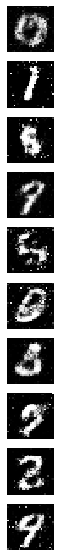

Time for epoch 249 is 41.864766120910645 sec


In [0]:
# STARTS TRAINING
train(train_dataset, training_title, False)

---

## VALIDATION

We consider that the GAN training is performed specifically with the goal of publicly sharing the generated data to allow others to train a ML model. 

For this reason, we validate the results by training models on the generated data, and finally, after deciding on a single final GAN properly validated, we test the results by applying on the real test data the models trained on the generated data.


### Choose model to use
Select one of the trials (a fixed GAN) to validate.

In [0]:
# EDIT THIS CELL
# Choose checkpoint (model) to use:
title = training_title
epoch_ckp = EPOCHS - 1

In [0]:
# DO NOT EDIT
checkpoint_name = checkpoint_dir + "/ckpt__" + str(title) + "__epoch=" + str(epoch_ckp) + "__-" + str(EPOCHS)

# RESTORE CHECKPOINT to variables defined on it
checkpoint.restore(checkpoint_name)

### Generate images

In [0]:
# Number of images to generate
N_GEN = 5000

In [0]:
N_GEN_per_CLASS = np.int(N_GEN/10)

tf.random.set_seed(10)
noise_GEN = tf.random.normal([N_GEN, Z_DIM])
labels_GEN = tf.Variable(np.array([1,0,0,0,0,0,0,0,0,0]*N_GEN_per_CLASS + 
                                   [0,1,0,0,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,1,0,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,1,0,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,1,0,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,1,0,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,1,0,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,1,0,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,0,1,0]*N_GEN_per_CLASS +
                                   [0,0,0,0,0,0,0,0,0,1]*N_GEN_per_CLASS, 
                                   dtype='float32').reshape((N_GEN,10)))

In [0]:
images_GEN = generator([noise_GEN, labels_GEN], training=False)
images_flat = layers.Flatten()(images_GEN)

In [0]:
labels_flat = tf.Variable(np.array([0]*N_GEN_per_CLASS + 
                                   [1]*N_GEN_per_CLASS +
                                   [2]*N_GEN_per_CLASS +
                                   [3]*N_GEN_per_CLASS +
                                   [4]*N_GEN_per_CLASS +
                                   [5]*N_GEN_per_CLASS +
                                   [6]*N_GEN_per_CLASS +
                                   [7]*N_GEN_per_CLASS +
                                   [8]*N_GEN_per_CLASS +
                                   [9]*N_GEN_per_CLASS, 
                                   dtype='float32').reshape((N_GEN,1)))

In [0]:
Y_train = labels_flat[:images_flat.shape[0]]
X_train = images_flat

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y_train_org = label_binarize(Y_train, classes=classes)
Y_train_vec = layers.Flatten()(Y_train_org)

### Get validation results

In [0]:
##### Vanilla Neural Network

tf.random.set_seed(100)
classifier_NN = OneVsRestClassifier(MLPClassifier(random_state=2, alpha=1))
NN_model = classifier_NN.fit(X_train, Y_train)

In [0]:
# ROC per class: Validating on REAL training dataset
Y_score = NN_model.predict_proba(train_images.reshape(60000,28*28*1))
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(train_labels_vec), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

['0 = 0.9156175436348475',
 '1 = 0.9109113359493617',
 '2 = 0.8448357629269958',
 '3 = 0.8882383073487151',
 '4 = 0.8701179827357689',
 '5 = 0.7105516226318085',
 '6 = 0.8777944388928687',
 '7 = 0.9483760771858529',
 '8 = 0.8067643790586637',
 '9 = 0.8317681787985552',
 'micro = 0.8623208510185186']

In [0]:
##### Logistic Regression

tf.random.set_seed(100)
classifier_LR = OneVsRestClassifier(LogisticRegression(solver='lbfgs', 
                                                       multi_class='multinomial', 
                                                       random_state=2))
LR_model = classifier_LR.fit(X_train, Y_train)

In [0]:
# ROC per class: Validating on REAL training dataset
Y_score = LR_model.predict_proba(train_images.reshape(60000,28*28*1))
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(train_labels_vec), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

['0 = 0.9080131050804862',
 '1 = 0.9085025633043666',
 '2 = 0.688334958329813',
 '3 = 0.8476950761008604',
 '4 = 0.859092995921667',
 '5 = 0.6976934534213066',
 '6 = 0.8401491488042284',
 '7 = 0.9362736392739307',
 '8 = 0.7712583595504482',
 '9 = 0.6496058728444396',
 'micro = 0.8156631838271604']

---

## TESTING

Model trained on generated data is tested on the real MNIST test dataset to evaluate utility.

### Load test data

In [0]:
(_, _), (X_test_org, Y_test_org) = tf.keras.datasets.mnist.load_data()

X_test_org = X_test_org.reshape(X_test_org.shape[0], 28, 28, 1).astype('float32')
X_test_org = (X_test_org - 127.5) / 127.5 # Normalize the images to [-1, 1]

Y_test_org = [int(y) for y in Y_test_org]
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y_test_org = label_binarize(Y_test_org, classes=classes)

X_test = layers.Flatten()(X_test_org)
Y_test = layers.Flatten()(Y_test_org)

### Get test results

In [0]:
##### Vanilla Neural Network

tf.random.set_seed(1)
classifier_NN = OneVsRestClassifier(MLPClassifier(random_state=2, alpha=1))
NN_model2 = classifier_NN.fit(X_train, Y_train)

['0 = 0.9209843205574912',
 '1 = 0.9120826096787098',
 '2 = 0.8375744032183334',
 '3 = 0.8955799072677013',
 '4 = 0.8764040147810286',
 '5 = 0.7093873271612597',
 '6 = 0.8654857706485947',
 '7 = 0.9404502724429309',
 '8 = 0.8325209035635588',
 '9 = 0.8333318452248085',
 'micro = 0.8635634855555555']

In [0]:
# ROC per class
Y_score = NN_model2.predict_proba(X_test)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_test), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

In [0]:
##### Logistic Regression

tf.random.set_seed(1)
classifier_LR = OneVsRestClassifier(LogisticRegression(solver='lbfgs', 
                                                       multi_class='multinomial', 
                                                       random_state=2))
LR_model2 = classifier_LR.fit(X_train, Y_train)

In [0]:
# ROC per class
Y_score = LR_model2.predict_proba(X_test)
false_positive_rate, true_positive_rate, roc_auc = compute_fpr_tpr_roc(np.array(Y_test), Y_score)
[str(au) + " = " + str(roc_auc[au]) for au in roc_auc]

['0 = 0.9117935200687813',
 '1 = 0.91025092491136',
 '2 = 0.6826285665138406',
 '3 = 0.8533424376920451',
 '4 = 0.8643882183584854',
 '5 = 0.7010692319963132',
 '6 = 0.8342065489788087',
 '7 = 0.9285441217033192',
 '8 = 0.7948869817561042',
 '9 = 0.623646220827148',
 'micro = 0.814876782222222']